In [1]:
import numpy as np
import pandas as pd

from src.constant import DATA_DIR, DATABASE_DIR, MAIN_DIR
from src.database import DB
from src.database.queries import *
from src.instance.InstanceList import InstanceList
from src.instance.TSP_Instance import TSP_from_index_file
from src.solver.TSP_LKH_Solver import TSP_LKH_Solver
from dataclasses import dataclass
import pathlib
pd.options.display.max_colwidth = 200
BASE_DIR = MAIN_DIR / "_archive" / "experiments" / "2025-01-27"

## loading

In [2]:
records = []

for tsp_size in ["200", "400", "600"]:
# for tsp_size in ["200"]:
    for n in ["30", "250", "500"]:
    # for n in ["30"]:
        for sur in ["plain", "sur-25", "sur-50", "sur-75"]:
            if sur == "plain":
                prefix = f"run-plain-{n}-*.db"
            else:
                prefix = f"run-{n}-{sur}-*.db"

            dir_ = BASE_DIR/ tsp_size / "database"
            databases = list(dir_.glob(prefix))

            for db_path in databases:
                print(db_path)
                db = DB(db_path)
                results = pd.read_sql_query("SELECT * FROM results", db._conn)

                # test_costs
                test_costs = (
                    results.loc[results["prefix"].str.startswith("test")]
                    .groupby(["instance_id", "prefix"])["cost"]
                    .min()
                    .reset_index()
                    .groupby("instance_id")["cost"]
                )


                # cost skip cut-offs
                def _cost_skip_cutoff(x):
                    count = x.shape[0]
                    x = x[x < 100.0]
                    x = x.sort_values()
                    idx = count // 2
                    if x.shape[0] <= idx:
                        return x.iloc[-1]
                    return x.iloc[idx]


                cost_skip_cutoff = test_costs.agg(_cost_skip_cutoff).mean()


                # par-10
                def _par10(x):
                    count = x.shape[0]
                    x = x.sort_values()
                    idx = count // 2
                    return x.iloc[idx]


                par10 = test_costs.agg(_par10).mean()


                # % of cut-offs
                def _test_pct_cutoff(x):
                    return (x == 100.0).mean()


                test_pct_cutoff = test_costs.agg(_test_pct_cutoff).mean()

                # record
                record = {
                    "tsp_size": tsp_size,
                    "n": n,
                    "sur": sur,
                    "db_path": db_path,
                    "cost_skip_cutoff": cost_skip_cutoff,
                    "par10": par10,
                    "test_pct_cutoff": test_pct_cutoff,
                }
                records.append(record)

df = pd.DataFrame(records)
#

C:\Users\zakrz\Documents\DataScience\praca magisterska\raw-algorithm-portfolios-main\_archive\experiments\2025-01-27\200\database\run-plain-30-974542.db
C:\Users\zakrz\Documents\DataScience\praca magisterska\raw-algorithm-portfolios-main\_archive\experiments\2025-01-27\200\database\run-plain-30-974544.db
C:\Users\zakrz\Documents\DataScience\praca magisterska\raw-algorithm-portfolios-main\_archive\experiments\2025-01-27\200\database\run-plain-30-974545.db
C:\Users\zakrz\Documents\DataScience\praca magisterska\raw-algorithm-portfolios-main\_archive\experiments\2025-01-27\200\database\run-plain-30-974546.db
C:\Users\zakrz\Documents\DataScience\praca magisterska\raw-algorithm-portfolios-main\_archive\experiments\2025-01-27\200\database\run-plain-30-974547.db
C:\Users\zakrz\Documents\DataScience\praca magisterska\raw-algorithm-portfolios-main\_archive\experiments\2025-01-27\200\database\run-plain-30-974548.db
C:\Users\zakrz\Documents\DataScience\praca magisterska\raw-algorithm-portfolios-ma

In [3]:
df['tsp_size'] = pd.Categorical(df['tsp_size'], categories=["200", "400", "600"], ordered=True)
df['n'] = pd.Categorical(df['n'], categories=["30", "250", "500"], ordered=True)
df['sur'] = pd.Categorical(df['sur'], categories=["plain", "sur-25", "sur-50", "sur-75"], ordered=True)

df["db_path"] = df["db_path"].astype(str)
df["db_path"] = df["db_path"].apply(lambda x: x[94:])

df

,tsp_size,n,sur,db_path,cost_skip_cutoff,par10,test_pct_cutoff
0,200,30,plain,experiments\2025-01-27\200\database\run-plain-30-974542.db,0.0730,0.0730,0.0000
1,200,30,plain,experiments\2025-01-27\200\database\run-plain-30-974544.db,0.0324,0.0324,0.0000
2,200,30,plain,experiments\2025-01-27\200\database\run-plain-30-974545.db,0.0646,0.0646,0.0000
3,200,30,plain,experiments\2025-01-27\200\database\run-plain-30-974546.db,0.0240,0.0240,0.0000
4,200,30,plain,experiments\2025-01-27\200\database\run-plain-30-974547.db,0.0314,0.0314,0.0000
...,...,...,...,...,...,...,...
344,600,500,sur-75,experiments\2025-01-27\600\database\run-500-sur-75-975520.db,1.5712,3.4324,0.0414
345,600,500,sur-75,experiments\2025-01-27\600\database\run-500-sur-75-975521.db,0.4168,0.4168,0.0034
346,600,500,sur-75,experiments\2025-01-27\600\database\run-500-sur-75-975522.db,1.6036,3.4894,0.0500
347,600,500,sur-75,experiments\2025-01-27\600\database\run-500-sur-75-975523.db,0.7850,0.7850,0.0054


In [4]:
df.to_parquet(BASE_DIR / "results.parquet")

## TEST

In [9]:
df = pd.read_parquet(BASE_DIR / "results.parquet")

In [10]:
def _aggregate(col, format="{:.3f}", axis=None):
    _ = (
        df.groupby(["sur", "n", "tsp_size"])[col].mean()
        .reset_index()
        .sort_values(by=["tsp_size", "sur", "n"])
        .reset_index(drop=True)
        .pivot_table(index=["n"], columns=["tsp_size", "sur"], values=col)
        .style
        .format(format)
    )
    print(_.to_latex())
    return _.background_gradient(cmap="Reds", axis=axis)

In [11]:
# averaged runtime (skip cut-offs)

_aggregate("cost_skip_cutoff", axis=None)

\begin{tabular}{lrrrrrrrrrrrr}
tsp_size & \multicolumn{4}{r}{200} & \multicolumn{4}{r}{400} & \multicolumn{4}{r}{600} \\
sur & plain & sur-25 & sur-50 & sur-75 & plain & sur-25 & sur-50 & sur-75 & plain & sur-25 & sur-50 & sur-75 \\
n &  &  &  &  &  &  &  &  &  &  &  &  \\
30 & 0.042 & 0.051 & 0.060 & 0.061 & 0.302 & 0.326 & 0.421 & 0.484 & 0.755 & 0.774 & 0.990 & 1.068 \\
250 & 0.039 & 0.045 & 0.047 & 0.048 & 0.267 & 0.331 & 0.352 & 0.336 & 0.622 & 0.634 & 0.752 & 0.807 \\
500 & 0.035 & 0.036 & 0.037 & 0.047 & 0.252 & 0.265 & 0.239 & 0.273 & 0.533 & 0.546 & 0.578 & 0.737 \\
\end{tabular}



In [12]:
df.loc[df["tsp_size"].eq("400") & df["n"].eq("500") & df["sur"].eq("sur-50")]

,tsp_size,n,sur,db_path,cost_skip_cutoff,par10,test_pct_cutoff
212,400,500,sur-50,experiments\2025-01-27\400\database\run-500-sur-50-951753.db,0.2390,0.2390,0.0000
213,400,500,sur-50,experiments\2025-01-27\400\database\run-500-sur-50-951756.db,0.2856,0.2856,0.0018
214,400,500,sur-50,experiments\2025-01-27\400\database\run-500-sur-50-951758.db,0.2562,0.2562,0.0000
215,400,500,sur-50,experiments\2025-01-27\400\database\run-500-sur-50-951759.db,0.1944,0.1944,0.0000
216,400,500,sur-50,experiments\2025-01-27\400\database\run-500-sur-50-951760.db,0.1874,0.1874,0.0000
217,400,500,sur-50,experiments\2025-01-27\400\database\run-500-sur-50-951761.db,0.2132,0.2132,0.0002
218,400,500,sur-50,experiments\2025-01-27\400\database\run-500-sur-50-951840.db,0.2212,0.2212,0.0000
219,400,500,sur-50,experiments\2025-01-27\400\database\run-500-sur-50-951841.db,0.3164,0.3164,0.0032


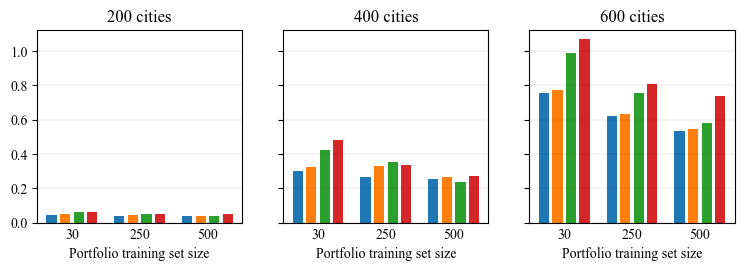

In [26]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Times New Roman'

n_to_x = {
    "30": 0,
    "250": 1,
    "500": 2,
}

sur_to_x = {
    "plain": 0.0,
    "sur-25": 0.2,
    "sur-50": 0.4,
    "sur-75": 0.6,
}

sur_to_color = {
    "plain": "C0",
    "sur-25": "C1",
    "sur-50": "C2",
    "sur-75": "C3",
}

_ = df.groupby(["sur", "n", "tsp_size"])["cost_skip_cutoff"].mean().reset_index()
_["x"] = _["n"].map(n_to_x).astype(float) + _["sur"].map(sur_to_x).astype(float)
_["color"] = _["sur"].map(sur_to_color)

fig, axs = plt.subplots(1, 3, figsize=(9, 2.5), sharey=True)
for i, (label, group) in enumerate(_.groupby("tsp_size")):
    ax = axs[i]
    ax.bar(group["x"], group["cost_skip_cutoff"], width=0.15, color=group["color"], alpha=1.0)
    ax.set_title(f"{label} cities")
    ax.set_xticks([0.3, 1.3, 2.3], labels=["30", "250", "500"])
    ax.tick_params(axis='x', length=0)
    ax.grid(axis='y', color='black', alpha=0.2, lw=0.3, ls="-")
    ax.set_xlabel("Portfolio training set size")

# # Create legend
# handles = [plt.Rectangle((0,0), 1 , 1, color=tsp_size_to_color[size]) for size in tsp_size_to_color]
# labels = ["200", "400", "600", "scaling"]
# axs[2].legend(handles, labels, title="TSP size", loc='upper right', bbox_to_anchor=(1.47, 1.04))

# axs[0].set_ylabel("Average runtime [s]")
# plt.suptitle("Reference cut-off time for TSP isntances of 600 cities:", y=1.05)
# plt.subplots_adjust(wspace=0.1)
# plt.savefig(BASE_DIR / "cost_skip_cutoff.pdf", bbox_inches='tight')
# plt.show()